# Определение стоимости автомобилей

## Загрузка исходных данных

Импорт необходимых библиотек, функций и моделей:

In [217]:
import pandas as pd
import numpy as np
import phik
import matplotlib.pyplot as plt
import seaborn as sns
import optuna 
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [218]:
data = pd.read_csv('/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


### Промежуточные выводы

- импортированы необходимые библиотеки, функции и модели;
- загружены исходные данные - датафрейм размером (354369,16).

## Изучение и предобработка данных

### Изучение исходных данных

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [220]:
data.shape

(354369, 16)

Датасет имеет 354369 объектов и 16 признаков, из которых 7 признаков - числовые с типом int64 и остальные с типом object.

Некоторые признаки имеют пропуски. Посчитаем их:

In [221]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

5 признаков (все нечисловые) имеют пропуски . И 2 из них имеют количество пропусков более 10% от общего числа объектов.

Общее число пропусков в датасете:

In [222]:
data.isna().sum().sum()#/data.shape[0]

181077

### Обработка числовых признаков

In [223]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Анализируя полученные значения, можно сделать вывод о наличии анаомальных значений по некоторым признакам.

Начнем с цены.

**Price**

В первую очередь бросается в глаза минимальная цена 0, что выглядит нелогичным, хотя и может быть вероятным (для привлечения внимания). Максимум выглядит логичным. Поскольку проблематично установить точный минимум цены - отсеим выбросы вне полуторного межквартильного интервала. Значение ниже 25%-квартили на полтора межквартильного интервала:

In [224]:
1050 - 1.5*(6400-1050)

-6975.0

Значение ниже нуля.

Будем ориентироваться на европейский рынок на примере сайта https://www.adesa.eu/en/findcar?prices=0%2C3000. Минимальная стоимость авто составляет 300 евро. Выберем это значение для ориентира и найдем количество объектов с ценой, меньшей 300 евро. Здесь также стоит отметить, что имеются значения с ценой от 1 евро. Возможно это связано с ценой за 1 кубический сантиметр объема двигателя. Но в датасете нет данных об объеме, поэтому эти значения мы использовать не сможем.

In [225]:
len(data.query('Price < 300'))

23163

In [226]:
len(data.query('Price < 300'))/data.shape[0] #  доля от обзего числа объектов

0.06536406965620582

Значений довольно много, но вместе они составляют около 6.5% от общего числа объектов. Кроме того, это целевой признак и обучать модели мы должны с учетом достоверного таргета. Поэтому удалим данные значения:

In [227]:
data = data.query('Price>=300')

In [228]:
data.shape

(331206, 16)

Посмотрим на данные еще раз:

In [229]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,331206.000000,331206.000000,331206.000000,331206.000000,331206.000000,331206.0,331206.000000
mean,4719.470097,2004.017995,113.026548,128362.891977,5.852790,0.0,50795.077752
std,4516.543060,67.451637,188.031233,37158.114376,3.668219,0.0,25701.328161
min,300.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30539.000000
50%,2999.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49624.000000
75%,6790.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71282.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**RegistrationYear**

Ориентируясь на данные одного из популярных европейских сайтов https://www.mobile.de/ru/категория/автомобиль/vhc:car,pgn:1,pgs:10,srt:year,sro:asc, можем определить нижний диапазон года регистрации - 1900.

Верхняя граница:

In [230]:
data.query('RegistrationYear <=2023')['RegistrationYear'].max()

2019

Количество аномалий:

In [231]:
len(data.query('RegistrationYear < 1900 or RegistrationYear > 2019'))

97

Удаляем аномалии по году регистрации:

In [232]:
data = data.query('1900 <= RegistrationYear <= 2019')


<div class="alert alert-block alert-info">
<b>Совет:</b> Советую посмотреть на дату выгрузки анкет - там тоже можно увидеть полезную информацию по поводу границ года регистраци.
</div>


<div class="alert alert-block alert-warning"> 
<b>Комментарий студента:</b> Дата выгрузки анкет имеет только 2016 год. Ниже код с анализом.
</div>

In [233]:
pd.DatetimeIndex(data['DateCrawled']).year.min()

2016

In [234]:
pd.DatetimeIndex(data['DateCrawled']).year.max()

2016

In [235]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,331109.000000,331109.000000,331109.000000,331109.000000,331109.000000,331109.0,331109.000000
mean,4719.647793,2003.335605,113.025279,128397.733073,5.854139,0.0,50797.212139
std,4516.418840,7.255242,187.964815,37106.351976,3.667613,0.0,25701.322091
min,300.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30539.000000
50%,2999.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49624.000000
75%,6790.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71287.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Power**

Для ограничения сверху взял в качестве ориентира данные с сайта https://www.drom.ru/info/misc/very-fast-cars-60255.html?ysclid=lg44pubx7e724159239. максимальная мощность составляет 1600 л.с.
Минимальное значение принимаем 4.2 л.с. (https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html).

Количество аномалий:

In [236]:
len(data.query('Power < 4.2 or Power > 1600'))

32127

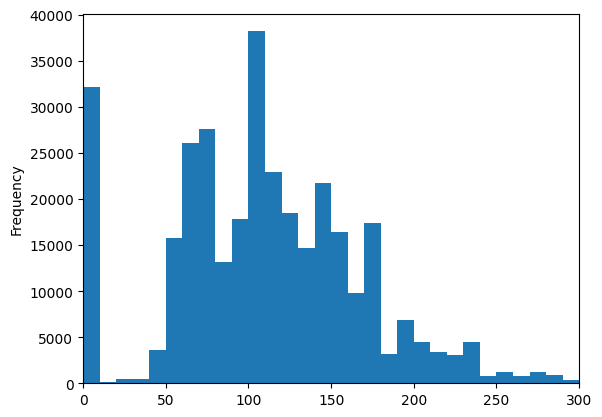

In [237]:
data['Power'].plot(kind='hist', xlim = [0, 300], bins=2000); # виден пик в пределах 0-10 л.с.

Аномалий много, но заполнить их по известным данным нельзя, поскольку нет данных о комплектации тем или иным типом двигателя.
Изучим часть из них.

In [238]:
data.query('Power < 4.2')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26 00:00:00,0,56759,2016-04-01 23:17:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,2016-03-05 18:57:45,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05 00:00:00,0,17034,2016-03-06 04:17:37
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23


In [239]:
data.query('Power > 1600')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
9664,2016-03-14 20:06:19,2599,NaN,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00,0,60326,2016-04-07 09:45:27
9875,2016-03-31 20:51:13,550,wagon,2003,manual,1753,focus,150000,1,gasoline,ford,yes,2016-03-31 00:00:00,0,21039,2016-03-31 20:51:13
19092,2016-03-20 17:54:04,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no,2016-03-20 00:00:00,0,21376,2016-03-23 02:48:53
20050,2016-03-26 19:46:06,2200,sedan,2002,auto,1704,e_klasse,150000,1,NaN,mercedes_benz,yes,2016-03-26 00:00:00,0,31812,2016-04-06 09:44:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348006,2016-03-22 13:44:40,355,sedan,1998,manual,1799,vectra,150000,6,petrol,opel,NaN,2016-03-22 00:00:00,0,39175,2016-03-29 16:45:09
348137,2016-03-16 21:48:39,850,sedan,1993,auto,9012,golf,150000,0,petrol,volkswagen,NaN,2016-03-16 00:00:00,0,14482,2016-04-03 09:17:43
348237,2016-04-04 12:38:11,3000,coupe,2007,manual,2007,corsa,150000,3,gasoline,opel,yes,2016-04-04 00:00:00,0,72218,2016-04-04 12:38:11
348668,2016-03-05 17:53:09,1000,wagon,1996,manual,2598,a6,150000,7,NaN,audi,NaN,2016-03-05 00:00:00,0,7646,2016-03-07 16:17:01


В целом данные адекватные: многие признаки имеют адекватные значения, поэтому при обучении они могут сыграть большую роль. В то же время имеется лишь 157 объектов с мощностью свыше 1600 л.с. - их мы можем удалить. 

In [240]:
data = data.query('Power <= 1600')

In [241]:
data.query('0 < Power < 4.2')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
9561,2016-04-04 07:58:34,9000,sedan,2009,manual,2,a4,5000,12,gasoline,audi,NaN,2016-04-04 00:00:00,0,12045,2016-04-06 10:17:01
16523,2016-03-26 10:48:50,4600,other,2012,manual,4,NaN,20000,9,gasoline,sonstige_autos,no,2016-03-26 00:00:00,0,40822,2016-03-26 10:48:50
20229,2016-03-17 22:48:49,4999,sedan,2003,manual,1,e_klasse,150000,12,gasoline,mercedes_benz,NaN,2016-03-17 00:00:00,0,66571,2016-03-17 23:44:50
30919,2016-03-24 18:47:46,1500,bus,2003,auto,2,NaN,150000,10,gasoline,hyundai,NaN,2016-03-24 00:00:00,0,40789,2016-03-26 04:15:35
33068,2016-03-29 15:44:33,5950,small,2004,manual,4,golf,80000,7,petrol,volkswagen,no,2016-03-29 00:00:00,0,64285,2016-04-06 01:15:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337076,2016-03-20 10:48:50,1100,small,2004,auto,4,NaN,20000,5,petrol,sonstige_autos,no,2016-03-20 00:00:00,0,42275,2016-03-21 12:46:57
339663,2016-03-15 08:54:44,5500,other,2005,auto,4,NaN,30000,9,gasoline,sonstige_autos,no,2016-03-15 00:00:00,0,42275,2016-03-18 01:17:28
340724,2016-04-02 19:45:53,4500,small,2007,auto,4,NaN,40000,7,gasoline,sonstige_autos,no,2016-04-02 00:00:00,0,27356,2016-04-06 19:46:52
349666,2016-03-07 21:36:46,1500,NaN,2016,NaN,2,NaN,150000,5,gasoline,volkswagen,NaN,2016-03-07 00:00:00,0,33330,2016-03-19 10:48:08


Значения с мощностью менее 4.2 л.с. можем считать аномалиями - удлаим их:

In [242]:
data = data.query('Power >= 4.2 or Power == 0')

Значения с нулевой мощностью могут быть обусловлены ннезаполнением данного поля. Заменим их на пропуски и в дальнейшем проведем заполнение:

In [243]:
data.loc[data['Power']==0, 'Power'] = np.nan

In [244]:
data['Power'].isna().sum() # число нулевых значений в признаке Power

31905

**Kilometer**

Значения пробега находятся в диапазоне от 5000 до 150000. Построим гистограмму:

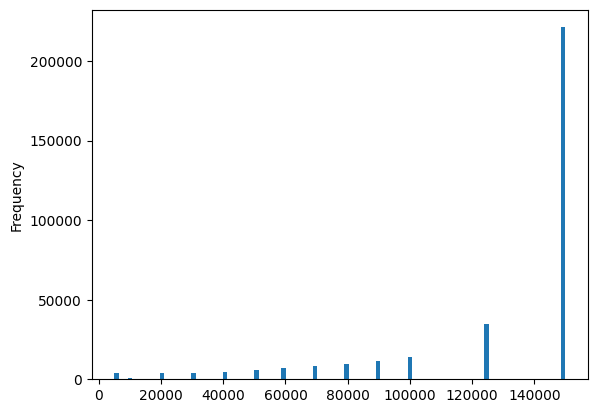

In [245]:
data['Kilometer'].plot(kind='hist', bins=100);

Есть пик на отметке 140000-150000, но удивляет, что нет пробега свыше, когда в базе представлены относительно старые авто (см. гистограмму ниже), пробег которых уж точно может быть за 200000 или 300000 км. Вероятно скручивают пробег.

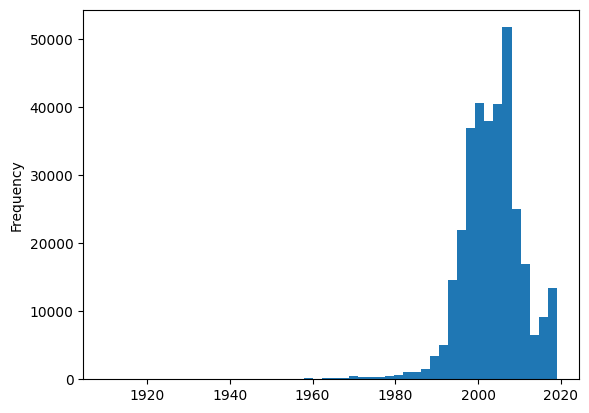

In [246]:
data['RegistrationYear'].plot(kind='hist', bins=50);

Значения признака оставляем. Аномалия соответствует значению 150000 км, но как-то исправить это мы не можем.

Корреляции между признаками не наблюдается:

In [247]:
data['Kilometer'].corr(data['RegistrationYear'])

-0.20102538542522236

**RegistrationMonth**

Посмотрим уникальные значения:

In [248]:
data['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

Значение "0" может означать, что информации по месяцу нет. Посмотрим их количество:

In [249]:
len(data.query('RegistrationMonth==0'))

28235

Значений много, удалять не будем. В то же время для заполнения нулевых значений отсуствует дополнительная информация. Оставим признак как есть.

**NumberOfPictures**

Посмотрим уникальные значения признака NumberOfPictures:

In [250]:
data['NumberOfPictures'].unique()

array([0])

Все значения нулевые, поэтому можем удалить признак:

In [251]:
data = data.drop('NumberOfPictures', axis=1)

**PostalCode**

Почтовый индекс владельца анкеты (пользователя) может косвенно указывать на цену, поскольку в разных странах могут быть свои ценовые условия.

Минимальное значение - 1067, что соответвует одному из районов Амстердама (https://xn----ctbhccqqveaj8ad3e3ci.cybo.com/нидерланды/1067-ES_амстердам/). Максимальный индекс 99998 соответствует Тюрингии (Германия).

Таким образом, признак PostalCode оставляем. Аномалий нет.

Вид датасета после обработки числовых признаков:

In [252]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,NaN,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,NaN,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,26624,2016-03-29 10:17:23
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,NaN,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439,2016-04-07 07:15:26


<Axes: ylabel='Frequency'>

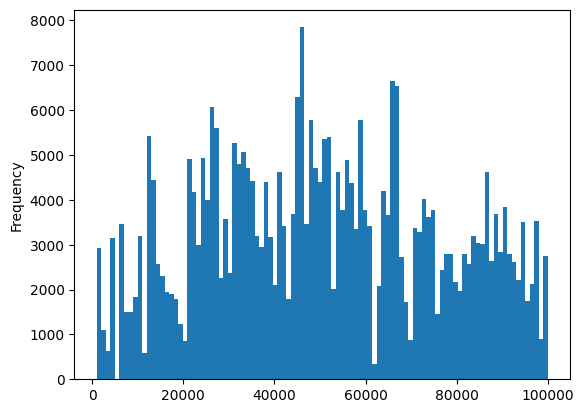

In [253]:
data['PostalCode'].plot(kind='hist', bins=100) # распределение индексов в пределах адекватных значений

Обновим индексы после удаления аномалий:

In [254]:
data = data.reset_index(drop=True)

### Обработка нечисловых признаков

Некоторые признаки являются неинформативными относительно предсказания цены авто:<br>**DateCrawled** (дата скачивания анкеты из базы) по дате идентичен признаку DateCreated (дата создания анкеты), за исключением времени.<br>
**LastSeen** — дата последней активности пользователя<br>
Удалим их:

In [255]:
data = data.drop(['DateCrawled', 'LastSeen'], axis=1)

In [256]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
0,480,NaN,1993,manual,NaN,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435
1,18300,coupe,2011,manual,190.0,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330882,1150,bus,2000,manual,NaN,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,26624
330883,2200,NaN,2005,NaN,NaN,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576
330884,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135
330885,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439


**DateCreated**

Оценим уникальные значения признака DateCreated:

In [257]:
data['DateCreated'].unique()

array(['2016-03-24 00:00:00', '2016-03-14 00:00:00',
       '2016-03-17 00:00:00', '2016-03-31 00:00:00',
       '2016-04-04 00:00:00', '2016-04-01 00:00:00',
       '2016-03-26 00:00:00', '2016-04-07 00:00:00',
       '2016-03-15 00:00:00', '2016-03-21 00:00:00',
       '2016-03-11 00:00:00', '2016-03-20 00:00:00',
       '2016-03-23 00:00:00', '2016-03-27 00:00:00',
       '2016-03-12 00:00:00', '2016-03-13 00:00:00',
       '2016-03-18 00:00:00', '2016-03-10 00:00:00',
       '2016-03-07 00:00:00', '2016-03-09 00:00:00',
       '2016-03-08 00:00:00', '2016-04-03 00:00:00',
       '2016-03-29 00:00:00', '2016-03-25 00:00:00',
       '2016-03-28 00:00:00', '2016-03-30 00:00:00',
       '2016-03-22 00:00:00', '2016-02-09 00:00:00',
       '2016-03-05 00:00:00', '2016-04-02 00:00:00',
       '2016-03-16 00:00:00', '2016-04-05 00:00:00',
       '2016-03-19 00:00:00', '2016-02-12 00:00:00',
       '2016-03-06 00:00:00', '2016-03-03 00:00:00',
       '2016-03-01 00:00:00', '2016-03-04 00:0

In [258]:
data['DateCreated'].max()

'2016-04-07 00:00:00'

In [259]:
data['DateCreated'].min()

'2014-03-10 00:00:00'

В базе представлены анкеты с 2014 по 2016 гг. На цену может влиять как сезонная составляющая (в зависимости от времени года, так и общий тренд на изменение цены в течение 2 лет), поэтому данный признак удалять не будем.

Заменим признак DateCreated на признаки year и month:

In [260]:
data['year'] = pd.DatetimeIndex(data['DateCreated']).year
data['month'] = pd.DatetimeIndex(data['DateCreated']).month
data = data.drop('DateCreated', axis=1)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,year,month
0,480,NaN,1993,manual,NaN,golf,150000,0,petrol,volkswagen,NaN,70435,2016,3
1,18300,coupe,2011,manual,190.0,NaN,125000,5,gasoline,audi,yes,66954,2016,3
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,90480,2016,3
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,91074,2016,3
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,60437,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330882,1150,bus,2000,manual,NaN,zafira,150000,3,petrol,opel,no,26624,2016,3
330883,2200,NaN,2005,NaN,NaN,NaN,20000,1,NaN,sonstige_autos,NaN,39576,2016,3
330884,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no,26135,2016,3
330885,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no,87439,2016,3


**VehicleType**

Оценим уникальные значения признака VehicleType:

In [261]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Все названия адекватные (https://engineeringlearn.com/top-9-types-of-cars-with-pictures-names-complete-details/), но есть пропуски и категория other.

**Gearbox**

Оценим уникальные значения признака Gearbox:

In [262]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Все значения объектов адекватные, но есть пропуски.

**Model**

Оценим уникальные значения признака Model:

In [263]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
       'fox', 'mati

In [264]:
data['Model'].value_counts().tail(10)

Model
gl                    12
kalina                 9
serie_2                8
samara                 7
i3                     7
elefantino             6
rangerover             4
serie_3                3
range_rover_evoque     2
serie_1                1
Name: count, dtype: int64

Все значения объектов адекватные, но есть пропуски.

Удалим редкое значение "serie_1" в признаке Model для возможности дальнейшего преобразования категориальных признаков.

In [265]:
data = data.query('Model!="serie_1"') 

**FuelType**

Оценим уникальные значения признака FuelType:

In [266]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Все значения объектов адекватные, но есть пропуски и значение other.

**Brand**

Оценим уникальные значения признака Brand:

In [267]:
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai', 'subaru',
       'volvo', 'mitsubishi', 'alfa_romeo', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'sonstige_autos', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

Все значения объектов адекватные.

Так как модель однозначно определяет бренд, то этот признак в приципе неинформативен, но поскольку в признаке Model есть пропуски, то признак Brand оставим для заполнения пропусков в признаке Model.

**Repaired**

Оценим уникальные значения признака Repaired:

In [268]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Все значения объектов адекватные, но есть пропуски.

Пропуски всех нечисловых признаков заполнить достоверными значениями нельзя, поскольку нет дополнительной информации. Например, тип кузова авто невозможно определить только по модели и марке, а других данных, уточняющих информацию нет:

In [269]:
data.groupby(by=['Brand', 'Model', 'VehicleType'], dropna=False)['Price'].count()

Brand       Model     VehicleType
alfa_romeo  145       coupe           2
                      other           1
                      sedan          10
                      small          15
                      NaN             7
                                     ..
volvo       xc_reihe  wagon          41
                      NaN             6
            NaN       sedan          21
                      wagon          42
                      NaN            26
Name: Price, Length: 1951, dtype: int64

 То же самое относится к виду топлива, модели, типу коробки передач и факту наличия ремонта.

Мы лишь можем заполнить пропуски примерными значениями, например, медианным или методом ближайших соседей. Выберем последний. Но перед заполнением сначала разделим данные на выборки и осуществим OHE-преобразование категориальных признаков.

### Разделение данных на выборки

Сначала разделим датафрейм на столбцы с целевым признаком - 'Price' и столбцы с остальными признаками:

In [270]:
features = data.drop('Price', axis=1)
target = data['Price']

Разделим полученные массивы на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. 

Сначала выделим тестовую выборку:

In [271]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

Чтобы сохранить соотношение 3:1:1 для получения валидационной выборки надо взять одну четвертую часть от тренировочной выборки выше:

In [272]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [273]:
target_train.mean()

4711.843429993301

In [274]:
target_valid.mean()

4732.227828399595

In [275]:
target_test.mean()

4734.385807972438

Доли классов целевого признака примерно одинаковы, поэтому параметр stratify не задействуем.

Размеры выборок:

In [276]:
features_test.shape[0] #тестовая выборка

66178

In [277]:
features_train.shape[0] #тренировочная выборка

198531

In [278]:
features_valid.shape[0] #валидационная выборка

66177

### OE-преобразование категориальных признаков

Преобразуем категориальные признаки в количественные с помощью метода OriginalEncoder:

Для начала сохраним отдельно массив с числовыми признаками:

In [279]:
n = [features_train[i].dtype != 'object' for i in features_train.columns]
features_train_num = features_train[features_train.columns[n]] #выборка train с численными признаками
features_valid_num = features_valid[features_valid.columns[n]] #выборка valid с численными признаками
features_test_num = features_test[features_test.columns[n]] #выборка test с численными признаками

Массив с категориальными признаками:

In [280]:
n = [features_train[i].dtype == 'object' for i in features_train.columns]
features_train_cat = features_train[features_train.columns[n]] #выборка train с катег. признаками
features_valid_cat = features_valid[features_valid.columns[n]] #выборка valid с катег. признаками
features_test_cat = features_test[features_test.columns[n]] #выборка test с катег. признаками

Преобразуем категориальные признаки для предсказания пропусков в признаке Power и других пяти категориальных признаках.

In [281]:
enc = OrdinalEncoder(handle_unknown='error') # создаем объект
enc.fit(features_train_cat) # обучаем объект

OrdinalEncoder()

In [282]:
#преобразуем признаки
orig_enc_cat_train = pd.DataFrame(
   enc.transform(features_train_cat), index=features_train_cat.index, columns=features_train_cat.columns).fillna(-1) 
orig_enc_cat_train

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
169263,0.0,1.0,248.0,6.0,24.0,-1.0
128736,0.0,1.0,234.0,2.0,36.0,0.0
318481,5.0,1.0,75.0,6.0,27.0,0.0
103623,7.0,0.0,31.0,6.0,1.0,0.0
25386,4.0,1.0,140.0,6.0,30.0,0.0
...,...,...,...,...,...,...
118939,4.0,0.0,19.0,6.0,2.0,0.0
157724,5.0,0.0,226.0,6.0,27.0,0.0
102896,1.0,1.0,8.0,6.0,25.0,0.0
325505,5.0,1.0,116.0,6.0,38.0,0.0


In [283]:
#объединяем числовые и нечисловые признаки после преобразования
features_train = pd.concat([features_train_num, orig_enc_cat_train], axis=1)
features_train

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,year,month,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
169263,1999,101.0,150000,12,88489,2016,3,0.0,1.0,248.0,6.0,24.0,-1.0
128736,2008,136.0,125000,3,71642,2016,4,0.0,1.0,234.0,2.0,36.0,0.0
318481,2001,58.0,100000,3,23626,2016,3,5.0,1.0,75.0,6.0,27.0,0.0
103623,2006,349.0,150000,9,38122,2016,4,7.0,0.0,31.0,6.0,1.0,0.0
25386,2010,125.0,125000,2,26160,2016,3,4.0,1.0,140.0,6.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118939,1988,188.0,125000,4,21521,2016,3,4.0,0.0,19.0,6.0,2.0,0.0
157724,2001,75.0,100000,0,12353,2016,4,5.0,0.0,226.0,6.0,27.0,0.0
102896,2011,120.0,70000,5,90552,2016,3,1.0,1.0,8.0,6.0,25.0,0.0
325505,1996,75.0,150000,1,13437,2016,3,5.0,1.0,116.0,6.0,38.0,0.0


Теперь то же самое с валидационной и тестовой выборками.

In [284]:
#преобразуем признаки
orig_enc_cat_valid = pd.DataFrame(
   enc.transform(features_valid_cat), index=features_valid_cat.index, columns=features_valid_cat.columns).fillna(-1)  

In [285]:
#объединяем числовые и нечисловые признаки после преобразования
features_valid = pd.concat([features_valid_num, orig_enc_cat_valid], axis=1)


In [286]:
#преобразуем признаки
orig_enc_cat_test = pd.DataFrame(
     enc.transform(features_test_cat), index=features_test_cat.index, columns=features_test_cat.columns).fillna(-1) 

In [287]:
#объединяем числовые и нечисловые признаки после преобразования
features_test = pd.concat([features_test_num, orig_enc_cat_test], axis=1)


### Заполнение пропусков

Заполним пропуски признака Power методом KNeighborsClassifier

In [288]:
features_neigh_train = features_train.query('~Power.isna()').drop('Power', axis=1) #тренировочная выборка

In [289]:
target_neigh_train = features_train.query('~Power.isna()')['Power'] #целевые значения тренировочной выборки

In [290]:
neigh = KNeighborsClassifier(n_neighbors=20) # создаем объект модели 
neigh.fit(features_neigh_train, target_neigh_train) # обучаем модель

KNeighborsClassifier(n_neighbors=20)

In [291]:
features_neigh_train_na = features_train.query(
    'Power.isna()').drop('Power', axis=1) #выделяем признаки, по которым надо предсказать
predictions_train = neigh.predict(features_neigh_train_na) # формируем предсказания

In [292]:
features_train.loc[features_neigh_train_na.index, ['Power']] = predictions_train 
#заполняем пропуски предсказаниями

In [293]:
features_neigh_valid_na = features_valid.query(
    'Power.isna()').drop('Power', axis=1) #выделяем признаки, по которым надо предсказать
predictions_valid = neigh.predict(features_neigh_valid_na) # формируем предсказания

In [294]:
features_valid.loc[features_neigh_valid_na.index, ['Power']] = predictions_valid 
#заполняем пропуски предсказаниями

In [295]:
features_neigh_test_na = features_test.query(
    'Power.isna()').drop('Power', axis=1) #выделяем признаки, по которым надо предсказать
predictions_test = neigh.predict(features_neigh_test_na) # формируем предсказания

In [296]:
features_test.loc[features_neigh_test_na.index, ['Power']] = predictions_test 
#заполняем пропуски предсказаниями

Теперь заполним пропуски в категориальных признаках. Подход будет тот же: создаем массивы признаков и целевого признака без пропусков для выбранного категориального признака, в котором заполняем пропуски. ОБучаем модель ближайшего соседа, затем предсказыыаем и заполняем пропуски.

Создадим функцию заполнения пропусков в категориальных признаках:

In [297]:
def fill_passes_KNeighborsClas(name_feature, n_neighbors):
    #возвращаем на место пропуски в признаке VehicleType (вместо -1)
    features_train[name_feature] = features_train[name_feature].replace(-1, np.nan)
    features_valid[name_feature] = features_valid[name_feature].replace(-1, np.nan)
    features_test[name_feature] = features_test[name_feature].replace(-1, np.nan)
    
    #тренировочная выборка
    features_neigh_train = features_train[~features_train[name_feature].isna()].drop(name_feature, axis=1)
    
    #целевые значения тренировочной выборки
    target_neigh_train = features_train[~features_train[name_feature].isna()][name_feature] 
    
    # создаем объект модели 
    neigh = KNeighborsClassifier(n_neighbors=20) 
    # обучаем модель
    neigh.fit(features_neigh_train, target_neigh_train) 
    
    #ТРЕЙНОВАЯ ВЫБОРКА
    
    #выделяем признаки, по которым надо предсказать
    features_neigh_train_na = features_train[features_train[name_feature].isna()].drop(name_feature, axis=1) 
    # формируем предсказания
    predictions_train = neigh.predict(features_neigh_train_na)
    
    #заполняем пропуски предсказаниями
    features_train.loc[features_neigh_train_na.index, [name_feature]] = predictions_train 

    #ВАЛИДАЦИОННАЯ ВЫБОРКА
    
    #выделяем признаки, по которым надо предсказать
    features_neigh_valid_na = features_valid[features_valid[name_feature].isna()].drop(name_feature, axis=1) 
    # формируем предсказания
    predictions_valid = neigh.predict(features_neigh_valid_na)
    
    #заполняем пропуски предсказаниями
    features_valid.loc[features_neigh_valid_na.index, [name_feature]] = predictions_valid 
    
    #ТЕСТОВАЯ ВЫБОРКА
    
    #выделяем признаки, по которым надо предсказать
    features_neigh_test_na = features_test[features_test[name_feature].isna()].drop(name_feature, axis=1) 
    # формируем предсказания
    predictions_test = neigh.predict(features_neigh_test_na)
    
    #заполняем пропуски предсказаниями
    features_test.loc[features_neigh_test_na.index, [name_feature]] = predictions_test 

Заполняем пропуски:

In [298]:
for i in features_train_cat.columns:
    if i=='Brand':
        continue
    fill_passes_KNeighborsClas(i, 20)

Все пропуски заполнены:

In [299]:
features_train.isna().sum()

RegistrationYear     0
Power                0
Kilometer            0
RegistrationMonth    0
PostalCode           0
year                 0
month                0
VehicleType          0
Gearbox              0
Model                0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [300]:
features_valid.isna().sum()

RegistrationYear     0
Power                0
Kilometer            0
RegistrationMonth    0
PostalCode           0
year                 0
month                0
VehicleType          0
Gearbox              0
Model                0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [301]:
features_test.isna().sum()

RegistrationYear     0
Power                0
Kilometer            0
RegistrationMonth    0
PostalCode           0
year                 0
month                0
VehicleType          0
Gearbox              0
Model                0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [302]:
features_train

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,year,month,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
169263,1999,101.0,150000,12,88489,2016,3,0.0,1.0,248.0,6.0,24.0,0.0
128736,2008,136.0,125000,3,71642,2016,4,0.0,1.0,234.0,2.0,36.0,0.0
318481,2001,58.0,100000,3,23626,2016,3,5.0,1.0,75.0,6.0,27.0,0.0
103623,2006,349.0,150000,9,38122,2016,4,7.0,0.0,31.0,6.0,1.0,0.0
25386,2010,125.0,125000,2,26160,2016,3,4.0,1.0,140.0,6.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118939,1988,188.0,125000,4,21521,2016,3,4.0,0.0,19.0,6.0,2.0,0.0
157724,2001,75.0,100000,0,12353,2016,4,5.0,0.0,226.0,6.0,27.0,0.0
102896,2011,120.0,70000,5,90552,2016,3,1.0,1.0,8.0,6.0,25.0,0.0
325505,1996,75.0,150000,1,13437,2016,3,5.0,1.0,116.0,6.0,38.0,0.0


### Масштабирование признакового пространства

Масштабируем признаки:

Создадим объект структуры StandardScaler() и настроим его на обучающих данных:

In [303]:
scaler = StandardScaler()
scaler.fit(features_train) 

StandardScaler()

Преобразуем столбцы функцией transform() и преобразуем массивы numpy в датафреймы с сохранением индексов разбиения исходного датасета на выборки:

In [304]:
features_train = pd.DataFrame(
    scaler.transform(features_train), index=features_train.index, columns=features_train.columns)

features_valid = pd.DataFrame(
    scaler.transform(features_valid), index=features_valid.index, columns=features_valid.columns)

features_test = pd.DataFrame(
    scaler.transform(features_test), index=features_test.index, columns=features_test.columns)

In [305]:
features_train

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,year,month,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
169263,-0.595770,-0.324227,0.582124,1.677473,1.464196,0.008398,-0.426102,-2.057644,0.493765,1.993498,0.68859,0.238710,-0.31688
128736,0.645962,0.285540,-0.092908,-0.777075,0.809269,0.008398,2.229174,-2.057644,0.493765,1.794991,-1.47084,1.137955,-0.31688
318481,-0.319829,-1.073368,-0.767939,-0.777075,-1.057353,0.008398,-0.426102,0.344017,0.493765,-0.459487,0.68859,0.463521,-0.31688
103623,0.370021,3.996402,0.582124,0.859290,-0.493821,0.008398,2.229174,1.304681,-2.025255,-1.083367,0.68859,-1.484844,-0.31688
25386,0.921902,0.093899,-0.092908,-1.049803,-0.958844,0.008398,-0.426102,-0.136316,0.493765,0.462155,0.68859,0.688332,-0.31688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118939,-2.113441,1.191478,-0.092908,-0.504348,-1.139185,0.008398,-0.426102,-0.136316,-2.025255,-1.253516,0.68859,-1.409907,-0.31688
157724,-0.319829,-0.777196,-0.767939,-1.595258,-1.495591,0.008398,2.229174,0.344017,-2.025255,1.681558,0.68859,0.463521,-0.31688
102896,1.059872,0.006789,-1.577977,-0.231620,1.544395,0.008398,-0.426102,-1.577312,0.493765,-1.409487,0.68859,0.313647,-0.31688
325505,-1.009680,-0.777196,0.582124,-1.322530,-1.453450,0.008398,-0.426102,0.344017,0.493765,0.121857,0.68859,1.287829,-0.31688


In [306]:
features_valid

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,year,month,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
612,0.094081,0.877884,0.582124,0.586563,0.412666,0.008398,-0.426102,-0.136316,0.493765,-1.366949,-1.47084,-1.409907,-0.31688
236939,-0.319829,-0.777196,-0.767939,1.677473,-1.090980,0.008398,-0.426102,0.344017,0.493765,1.681558,0.68859,0.463521,-0.31688
286290,1.611753,-0.167430,-3.198053,-0.504348,-1.556702,0.008398,-0.426102,-2.057644,0.493765,1.284543,-1.47084,0.463521,-0.31688
229763,-1.975471,-1.125634,-1.307965,-1.322530,-0.348934,0.008398,2.229174,-0.136316,0.493765,0.121857,0.68859,1.287829,-0.31688
238251,-0.871710,-1.038524,0.582124,-0.777075,-0.143324,0.008398,-0.426102,0.344017,0.493765,0.292006,0.68859,-0.810410,-0.31688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68935,0.921902,-0.254539,0.582124,-0.777075,0.136342,0.008398,-0.426102,1.304681,0.493765,0.490513,0.68859,-1.110158,-0.31688
68515,0.783932,-0.742352,-1.577977,0.859290,1.570869,0.008398,-0.426102,0.344017,0.493765,0.830812,0.68859,-0.885347,-0.31688
114239,0.370021,0.999837,0.582124,-0.777075,1.504276,0.008398,-0.426102,-2.057644,0.493765,-0.360233,-1.47084,1.137955,-0.31688
265701,-0.319829,-0.184852,-0.092908,0.586563,0.631571,0.008398,-0.426102,-1.577312,-2.025255,-1.409487,0.68859,0.313647,-0.31688


In [307]:
features_test

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,year,month,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
222950,-0.319829,0.181008,0.582124,1.677473,-0.637309,0.008398,-0.426102,1.304681,0.493765,0.660663,-1.47084,-0.810410,-0.31688
194210,-2.527352,-0.777196,-0.767939,-1.322530,-0.990916,0.008398,-0.426102,-0.136316,-2.025255,-1.055009,0.68859,-0.061039,-0.31688
48925,-1.699531,-1.212743,-1.307965,0.859290,-1.708043,0.008398,-0.426102,0.344017,0.493765,0.830812,0.68859,1.287829,-0.31688
101214,-0.595770,-1.143056,0.582124,1.404745,1.499883,0.008398,-0.426102,0.344017,0.493765,0.618125,0.68859,0.163773,-0.31688
120113,0.370021,-1.038524,0.582124,1.404745,-0.067674,0.008398,-0.426102,-0.136316,0.493765,1.681558,-1.47084,0.313647,-0.31688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16736,0.921902,1.400541,0.582124,-0.504348,-0.411678,0.008398,-0.426102,-1.577312,0.493765,1.653200,0.68859,-1.484844,-0.31688
27440,1.473782,0.285540,-2.388015,-1.595258,0.048563,0.008398,-0.426102,-0.136316,0.493765,1.525588,0.68859,1.063018,-0.31688
241787,-1.009680,0.529446,0.582124,-1.322530,1.458714,0.008398,-0.426102,-0.136316,-2.025255,-0.686352,0.68859,-0.061039,-0.31688
251395,-0.457800,-0.097742,0.582124,-0.777075,1.357989,0.008398,-0.426102,1.304681,-2.025255,0.405439,0.68859,0.463521,-0.31688


### Проверка признаков на мультиколлинеарность

Проверим на мультиколлинеарность сформированный обучающий набор признаков:

interval columns not set, guessing: ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode', 'year', 'month', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


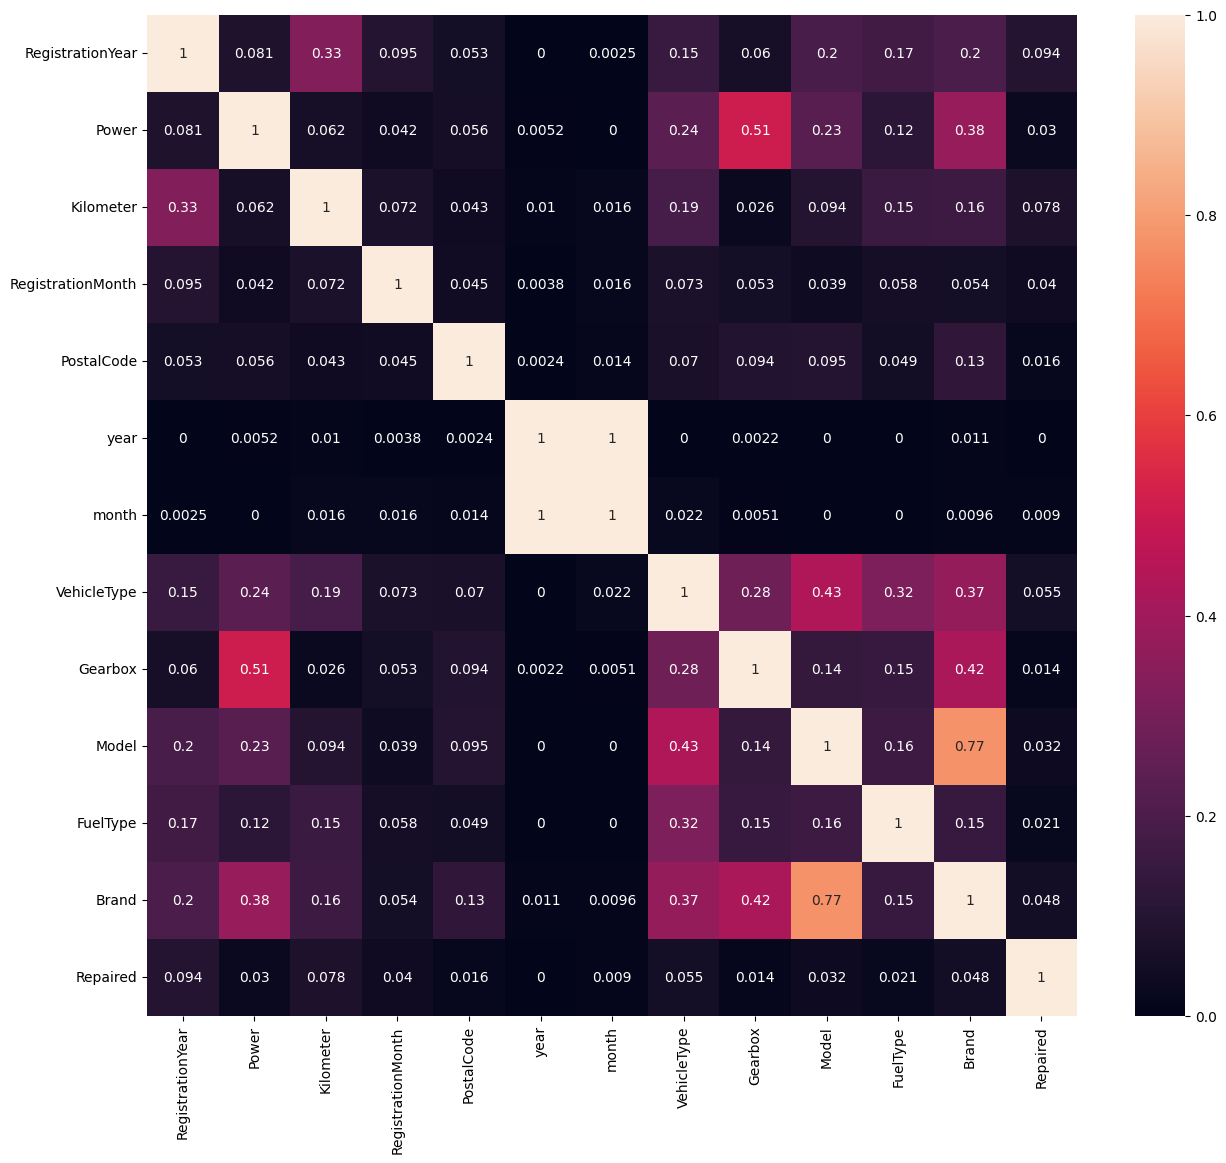

In [308]:
plt.figure(figsize=(15, 13));
sns.heatmap(features_train.phik_matrix(), annot=True);

Наблюдается коллинеарность у признаков модель и бренд, что логично, так как как правило название модели определяет название бренда. Поэтому бренд можем исключить из рассмотрения. НО я решил его оставить.
Также коллинеарны год и месяц создания анкеты, что логично, поскольку множество объявлений сделано в один и тот же месяц конкретного года.

### Промежуточные выводы:

Изучены данные исходного датафрейма: 
- датасет имеет 354369 объектов и 16 признаков, из которых 7 признаков - числовые с типом int64 и остальные с типом object; 
- 5 признаков (все нечисловые) имеют пропуски, 2 из них имеют количество пропусков более 10% от общего числа объектов, общее число пропусков в датасете - 181077.

Проведена обработка числовых признаков:
- значения целевого признака Price отфильтрованы по условию Price >= 300, ориентируясь на типовой европейский сайт продажи бу машин, удалено 23163 аномальных объекта;
- признак RegistrationYear отфильтрован по условию 1900 <= RegistrationYear <= 2019, также с учетом данных с типового европейского сайта продажи бу машин, удалено 97 аномальных значений;
- признак Power имеет 32127 значений до 4.2 л.с. и свыше 1600 л.с. (с учетом данных с типового европейского сайта продажи бу машин), 157 аномалий, превышающих 1600 л.с. удалены, 65 аномалий между 0 и 4.2 л.с. удалены, 31905 аномалий, соответствующих нулевой мощности (продавцы не заполнили умышленно или не знали информацию) заполнены методом KNeighbourClassifier с учетом данных других признаков;
- признак Kilometer имеет пик в районе 150000 км, возможно многие продают машины после этого пробега, что соотвтествует примерно 5 годам, когда заканечивается гарантия на все агрегаты авто, кроме того, продавцы могут сматывать пробег до этого значения; значения не фильтровались, пропусков нет;
- признак RegistrationMonth имеет 28235 нулевых значений, что может значить отсуствие информации у продавцов или нежелание заполнять его, значений много, не удалялись, заполнение нулевых значений не проводилось;
- признак NumberOfPictures полнностью удален, поскольку имеет все нулевые значения;
- признак PostalCode имеет адекватные значения без пропусков и аномалий;
- обновлены индексы обработанного датафрейма.

Проведена обработка нечисловых признаков:
- удалены неинформативные признаки DateCrawled и LastSeen;
- признак DateCreated заменен на признаки year и month;
- признак VehicleType имеет адекватные значения, но 37490 из них - пропуски;
- признак Gearbox имеет адекватные значения, но 19833 из них - пропуски;
- признак Model имеет адекватные значения, но 19705 из них - пропуски;
- признак FuelType имеет адекватные значения, но 32895 из них - пропуски;
- признак Repaired имеет адекватные значения, но 71154 из них - пропуски.

Итоговый размер датасета после предварительной обработки: (330887, 14).

Данные разделены на выборки:
- перед заполнением пропусков данные разделены на обучающую (198531, 14), валидационную (66177, 14) и тестовую (66178, 14) выборки.

Проведено преобразование категориальных признаков в числовые:
- категориальные признаки преобразованы в числовые методом Original_encoder.

Заполнены пропуски:
- значения пяти вышеперечисленных признаков, а также нулевые значения признака Power заполнены методом KNeighbourClassifier.

Масштабированы признаки:
- признаки масштабированы с помощью метода StandardScaler().

Проведена проверка признаков на мультиколлинеарность: 
- наблюдается коллинеарность у признаков модель и бренд, что логично, так как как правило название модели определяет название бренда. Поэтому бренд можем исключить из рассмотрения. Также коллинеарны год и месяц создания анкеты, что логично, поскольку множество объявлений сделано в один и тот же месяц конкретного года. Признаки Brand и Month были оставлены,, поскольку в дальнейшем не планировал использовать линейную регрессию.

## Подготовка выборок для обучения моделей

Подготовка выборок сделана на предыдущем этапе, поскольку разбивать данные на выборки целесообразно перед преобразование категориальных признаков и их масштабирования, чтобы избежать утечки данных в тест.

### Промежуточные выводы

Данные разделены по целевому и нецелевым признакам, а затем разделены на обучающую (198531, 14), валидационную (66177, 14) и тестовую (66178, 14) выборки в соотношении 3:1:1.

## Обучение моделей

Исследуем четыре модели: решающее дерево, случайный лес, LightGBM и Catboost.

### Decision tree

Используем optuna для подбора параметров.

In [309]:
%%time
def objective_cv(trial):
    
    depth = trial.suggest_int('max_depth', 1, 20) # задаем диапазон параметра
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345) # формируем объект модели 
    model.fit(features_train, target_train) # обучаем модель
    predicted_valid = model.predict(features_valid) # формируем предсказания

    return (mean_squared_error(target_valid, predicted_valid))**0.5

study = optuna.create_study(direction='minimize') # создаем объект исследования, цель - минимазация метрики RMSE
study.optimize(objective_cv, n_trials=10)  # количество прогонов с разными параметрами
study.best_params, study.best_value

[I 2023-04-11 13:41:30,108] A new study created in memory with name: no-name-d4c88d11-a640-4b9b-86f8-445f187ab388
[I 2023-04-11 13:41:30,700] Trial 0 finished with value: 2081.939466791733 and parameters: {'max_depth': 11}. Best is trial 0 with value: 2081.939466791733.
[I 2023-04-11 13:41:30,817] Trial 1 finished with value: 3332.118368962274 and parameters: {'max_depth': 2}. Best is trial 0 with value: 2081.939466791733.
[I 2023-04-11 13:41:31,771] Trial 2 finished with value: 2209.7183674396547 and parameters: {'max_depth': 20}. Best is trial 0 with value: 2081.939466791733.
[I 2023-04-11 13:41:32,339] Trial 3 finished with value: 2081.939466791733 and parameters: {'max_depth': 11}. Best is trial 0 with value: 2081.939466791733.
[I 2023-04-11 13:41:32,953] Trial 4 finished with value: 2063.2202301138286 and parameters: {'max_depth': 12}. Best is trial 4 with value: 2063.2202301138286.
[I 2023-04-11 13:41:33,567] Trial 5 finished with value: 2063.2202301138286 and parameters: {'max_d

CPU times: user 5.28 s, sys: 25.2 ms, total: 5.31 s
Wall time: 5.31 s


({'max_depth': 12}, 2063.2202301138286)

Оценим время обучения и время предсказания для лучшего значения метрики:

In [310]:
model = DecisionTreeRegressor(max_depth=study.best_params['max_depth'], random_state=12345)

Время обучения:

In [311]:
time_train_DT = %timeit -n1 -r1 -o model.fit(features_train, target_train)
time_train_DT.average

604 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


0.6037540239999544

Время предсказания:

In [312]:
time_pred_DT = %timeit -n1 -r1 -o model.predict(features_valid)
predicted_valid = model.predict(features_valid)
time_pred_DT.average

9.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


0.00924290300008579

Метрика RMSE:

In [313]:
RMSE_DT = mean_squared_error(target_valid, predicted_valid)**0.5
RMSE_DT

2063.2202301138286

### Random forest

Используем optuna для подбора параметров.

Считает долго - сократил диапазон параметров.

In [314]:
%%time

def objective_cv(trial):
    
    depth = trial.suggest_int('max_depth', 1, 21, step=4)
    n_est = trial.suggest_int('n_estimators', 10, 30, step=10)
    
    model = RandomForestRegressor(max_depth=depth, n_estimators=n_est, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    return mean_squared_error(target_valid, predicted_valid)**0.5

study = optuna.create_study(direction='minimize')
study.optimize(objective_cv, n_trials=10)
study.best_params, study.best_value

[I 2023-04-11 13:41:36,071] A new study created in memory with name: no-name-4a2b2c79-7e7b-4b35-8f82-56cb96208cd1
[I 2023-04-11 13:41:49,901] Trial 0 finished with value: 1843.1477508014455 and parameters: {'max_depth': 13, 'n_estimators': 30}. Best is trial 0 with value: 1843.1477508014455.
[I 2023-04-11 13:42:04,076] Trial 1 finished with value: 1843.1477508014455 and parameters: {'max_depth': 13, 'n_estimators': 30}. Best is trial 0 with value: 1843.1477508014455.
[I 2023-04-11 13:42:10,132] Trial 2 finished with value: 2446.169144965822 and parameters: {'max_depth': 5, 'n_estimators': 30}. Best is trial 0 with value: 1843.1477508014455.
[I 2023-04-11 13:42:12,159] Trial 3 finished with value: 2443.521294565681 and parameters: {'max_depth': 5, 'n_estimators': 10}. Best is trial 0 with value: 1843.1477508014455.
[I 2023-04-11 13:42:22,339] Trial 4 finished with value: 2062.6131794340095 and parameters: {'max_depth': 9, 'n_estimators': 30}. Best is trial 0 with value: 1843.14775080144

CPU times: user 1min 9s, sys: 246 ms, total: 1min 9s
Wall time: 1min 9s


({'max_depth': 13, 'n_estimators': 30}, 1843.1477508014455)

Оценим время обучения и время предсказания для лучшего значения метрики:

In [315]:
model = RandomForestRegressor(
    max_depth=study.best_params['max_depth'], n_estimators=study.best_params['n_estimators'], random_state=12345)

Время обучения:

In [316]:
time_train_RF = %timeit -n1 -r1 -o model.fit(features_train, target_train)
time_train_RF.average

13.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


13.597985321000124

Время предсказания:

In [317]:
time_pred_RF = %timeit -n1 -r1 -o model.predict(features_valid)
predicted_valid = model.predict(features_valid)
time_pred_RF.average

244 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


0.24448574100006226

Метрика RMSE:

In [318]:
RMSE_RF = mean_squared_error(target_valid, predicted_valid)**0.5
RMSE_RF

1843.1477508014455

### Light GBM

Используем optuna для подбора параметров.

In [319]:
%%time

def objective_cv(trial):
    
    leaves = trial.suggest_int('leaves', 31, 61, step=10)
    n_est = trial.suggest_int('n_estimators', 100, 200, step=50)
    
    model = lgbm.LGBMRegressor(objective="regression", n_estimators=n_est, metric='rmse', num_leaves=leaves)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    return (mean_squared_error(target_valid, predicted_valid))**0.5

study = optuna.create_study(direction='minimize')
study.optimize(objective_cv, n_trials=10)
study.best_params, study.best_value

[I 2023-04-11 13:42:59,970] A new study created in memory with name: no-name-9a7c2256-a78e-464b-a5db-0b4eb017789d
[I 2023-04-11 13:43:01,300] Trial 0 finished with value: 1742.6450916271995 and parameters: {'leaves': 41, 'n_estimators': 150}. Best is trial 0 with value: 1742.6450916271995.
[I 2023-04-11 13:43:02,331] Trial 1 finished with value: 1738.1405441692157 and parameters: {'leaves': 31, 'n_estimators': 200}. Best is trial 1 with value: 1738.1405441692157.
[I 2023-04-11 13:43:03,161] Trial 2 finished with value: 1763.0640468200427 and parameters: {'leaves': 31, 'n_estimators': 150}. Best is trial 1 with value: 1738.1405441692157.
[I 2023-04-11 13:43:03,993] Trial 3 finished with value: 1763.0640468200427 and parameters: {'leaves': 31, 'n_estimators': 150}. Best is trial 1 with value: 1738.1405441692157.
[I 2023-04-11 13:43:04,878] Trial 4 finished with value: 1742.6450916271995 and parameters: {'leaves': 41, 'n_estimators': 150}. Best is trial 1 with value: 1738.1405441692157.
[

CPU times: user 1min 9s, sys: 3.1 s, total: 1min 12s
Wall time: 9.8 s


({'leaves': 61, 'n_estimators': 200}, 1699.4754954675366)

Оценим время обучения и время предсказания для лучшего значения метрики:

In [320]:
model = lgbm.LGBMRegressor(
    objective="regression", n_estimators=study.best_params['n_estimators'], \
    metric='rmse', num_leaves=study.best_params['leaves'])

Время обучения:

In [321]:
time_train_LGBM = %timeit -n1 -r1 -o model.fit(features_train, target_train)
time_train_LGBM.average

1.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.0371692030003032

Время предсказания:

In [322]:
time_pred_LGBM = %timeit -n1 -r1 -o model.predict(features_valid)
predicted_valid = model.predict(features_valid)
time_pred_LGBM.average

245 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


0.24471972999981517

Метрика RMSE:

In [323]:
RMSE_LGBM = mean_squared_error(target_valid, predicted_valid)**0.5
RMSE_LGBM

1699.4754954675366

### CatBoost

Используем optuna для подбора параметров.

In [324]:
%%time

def objective_cv(trial):
    
    depth = trial.suggest_int('max_depth', 1, 16, step=5)
    n_est = trial.suggest_int('n_estimators', 10, 50, step=20)
    
    model = CatBoostRegressor(random_state=12345, max_depth=depth, n_estimators=n_est, verbose=False)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    return (mean_squared_error(target_valid, predicted_valid))**0.5

study = optuna.create_study(direction='minimize')
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective_cv, n_trials=10)
study.best_params, study.best_value

[I 2023-04-11 13:43:11,318] A new study created in memory with name: no-name-8ec188c0-6c4f-4c28-a681-1b9e93e570b0
[I 2023-04-11 13:43:17,613] Trial 0 finished with value: 1829.9320339193719 and parameters: {'max_depth': 16, 'n_estimators': 10}. Best is trial 0 with value: 1829.9320339193719.
[I 2023-04-11 13:43:49,735] Trial 1 finished with value: 1754.2077536501934 and parameters: {'max_depth': 16, 'n_estimators': 50}. Best is trial 1 with value: 1754.2077536501934.
[I 2023-04-11 13:43:56,284] Trial 2 finished with value: 1829.9320339193719 and parameters: {'max_depth': 16, 'n_estimators': 10}. Best is trial 1 with value: 1754.2077536501934.
[I 2023-04-11 13:43:56,441] Trial 3 finished with value: 2069.0600445088203 and parameters: {'max_depth': 6, 'n_estimators': 10}. Best is trial 1 with value: 1754.2077536501934.
[I 2023-04-11 13:43:57,829] Trial 4 finished with value: 1746.5026912457727 and parameters: {'max_depth': 11, 'n_estimators': 50}. Best is trial 4 with value: 1746.5026912

CPU times: user 1min 46s, sys: 45 s, total: 2min 31s
Wall time: 48 s


({'max_depth': 11, 'n_estimators': 50}, 1746.5026912457727)

Оценим время обучения и время предсказания для лучшего значения метрики:

In [325]:
model = CatBoostRegressor(
    random_state=12345, max_depth=study.best_params['max_depth'], \
    n_estimators=study.best_params['n_estimators'], verbose=False)

Время обучения:

In [326]:
time_train_CatB = %timeit -n1 -r1 -o model.fit(features_train, target_train)
time_train_CatB.average

1.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.6692954190002638

Время предсказания:

In [327]:
time_pred_CatB = %timeit -n1 -r1 -o model.predict(features_valid)
predicted_valid = model.predict(features_valid)
time_pred_CatB.average

11.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


0.011588149000090198

Метрика RMSE:

In [328]:
RMSE_CatB = mean_squared_error(target_valid, predicted_valid)**0.5
RMSE_CatB

1746.5026912457727

### Промежуточные выводы

Исследованы четыре модели: решающее дерево, случайный лес, LightGBM и Catboost. Гиперпараметры подбирались с помощью оптимизатора optuna. В некоторых случаях диапазон исследуемых гиперпараметров был уменьшен для снижения времени работы алгоритма.

Модель решающее дерево исследовалась при изменении параметра max_depth.<br>
Модель случайный лес исследовалась при изменении параметров max_depth и число оценщиков.<br>
Модель LightGBM исследовалась при изменении параметров число оценщиков и число листьев.<br>
Модель Catboost исследовалась при изменении параметров max_depth и число оценщиков.<br>

В ходе исследования получены модели с подходящими параметрами:
- DecisionTreeRegressor(max_depth=12, random_state=12345);
- RandomForestRegressor(max_depth=21, n_estimators=10, random_state=12345);
- LGBMRegressor(n_estimators=200, num_leaves=s61);
- CatBoostRegressor(random_state=12345, max_depth=11, n_estimators=50).

По каждой из вышеперечисленных моделей рассчитаны значения критериев - метрики RMSE, времени обучения модели и времени предсказания модели.

## Анализ моделей

По условию проекта при анализе моделей необходимо использовать три критерия: метрика RMSE, время обучения модели и время предсказания модели.

Ограничения на критерии: 
- метрика RMSE < 2500, 
- время обучения модели и время предсказания модели должны быть минимальны. 

Для анализа моделей по заданным критериям создадим датафрейм с полученными на предыдущем шаге значениями:

In [329]:
df = pd.DataFrame(
   ....:     {
   ....:         'RMSE': [RMSE_DT, RMSE_RF, RMSE_LGBM, RMSE_CatB],
                 'time_train': [time_train_DT.average, time_train_RF.average, \
                                time_train_LGBM.average, time_train_CatB.average],
   ....:         'time_predict': [time_pred_DT.average, time_pred_RF.average, \
                                  time_pred_LGBM.average, time_pred_CatB.average]

   ....:     },
   ....:     index=['Decision Tree', 'Random Forest', 'LightGBM', 'Catboost'],
             columns=['RMSE', 'time_train', 'time_predict']
    
   ....: )

In [330]:
df

,RMSE,time_train,time_predict
Decision Tree,2063.220230,0.603754,0.009243
Random Forest,1843.147751,13.597985,0.244486
LightGBM,1699.475495,1.037169,0.244720
Catboost,1746.502691,1.669295,0.011588


<Axes: title={'center': 'RMSE'}>

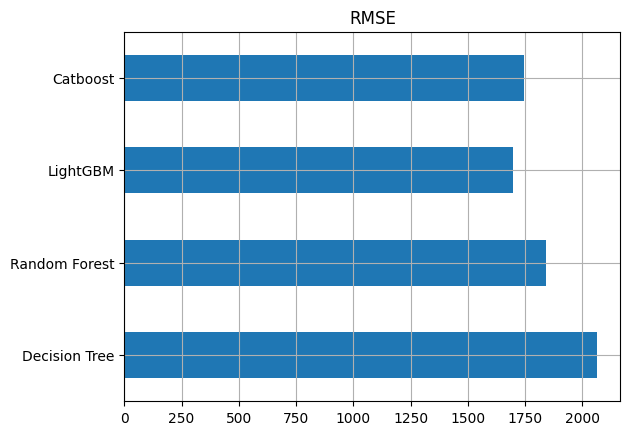

In [331]:
df['RMSE'].plot(kind='barh', grid=True, title='RMSE')

<Axes: title={'center': 'Анализ времени обучения моделей'}>

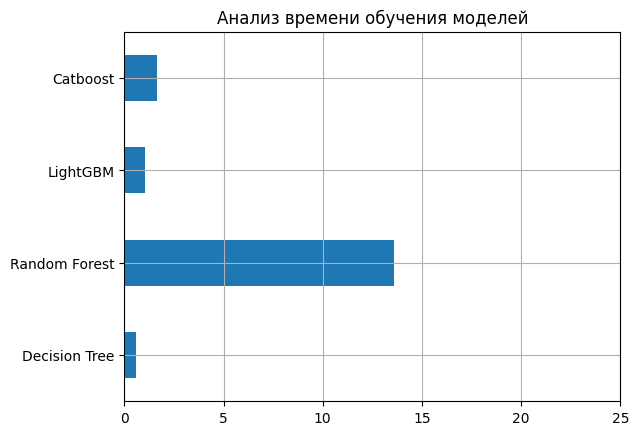

In [332]:
df['time_train'].plot(kind='barh', grid=True, title='Анализ времени обучения моделей', xlim=[0, 25])

Специально сделал тот же масштаб, что и при анализе времени обучения.

<Axes: title={'center': 'Анализ времени предсказания'}>

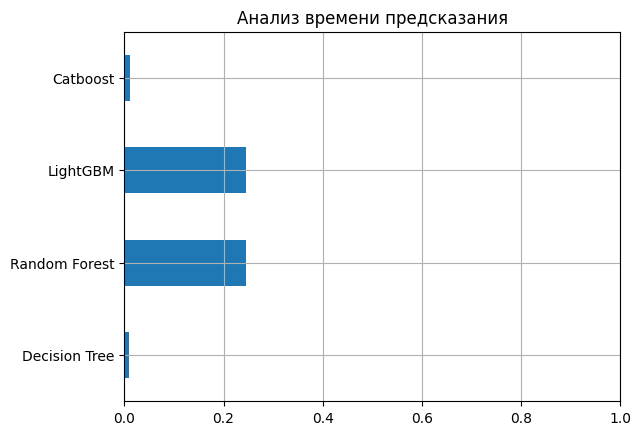

In [333]:
df['time_predict'].plot(kind='barh', grid=True, title='Анализ времени предсказания', xlim=[0, 1])

### Промежуточные выводы

Анализируя данные полученного датaфрейма и графики, можно сделать вывод:

- наилучшей моделью по качеству предсказания является LGBMRegressor(n_estimators=200, num_leaves=s61).

- наилучшей моделью по времени обучения и предсказания является DecisionTreeRegressor(max_depth=12, random_state=12345).

- в совокупности по всем трем критериям наилучшей моделью является модель DecisionTreeRegressor(max_depth=12, random_state=12345), несмотря на худшую метрику RMSE, которая все же удовлетворяет требуемому значению <2500.

В то же время необходимо отметить важное обстоятельство: в условиях ограничения на временные ресурсы при выполнении проекта мы ограничиваемся числом прогонов оптимизатора по параметрам, а также используем не все параметры моделей, в сявзи с чем при запуске ноутбука значения рассчитываемых критериев имеют значительный разброс и тип и параметры лучшей модели меняются. Поэтому более корректным будет отметить, что при данном запуске лучшей является модель DecisionTreeRegressor(max_depth=12, random_state=12345).

## Проверка качества выбранной модели

In [334]:
model = DecisionTreeRegressor(max_depth=12, random_state=12345)

%timeit -n1 -r1 -o model.fit(features_train, target_train)
model.fit(features_train, target_train)
%timeit -n1 -r1 -o model.predict(features_test)
predicted_test = model.predict(features_test)
mean_squared_error(target_test, predicted_test)**0.5

657 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.75 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2050.7111538802847

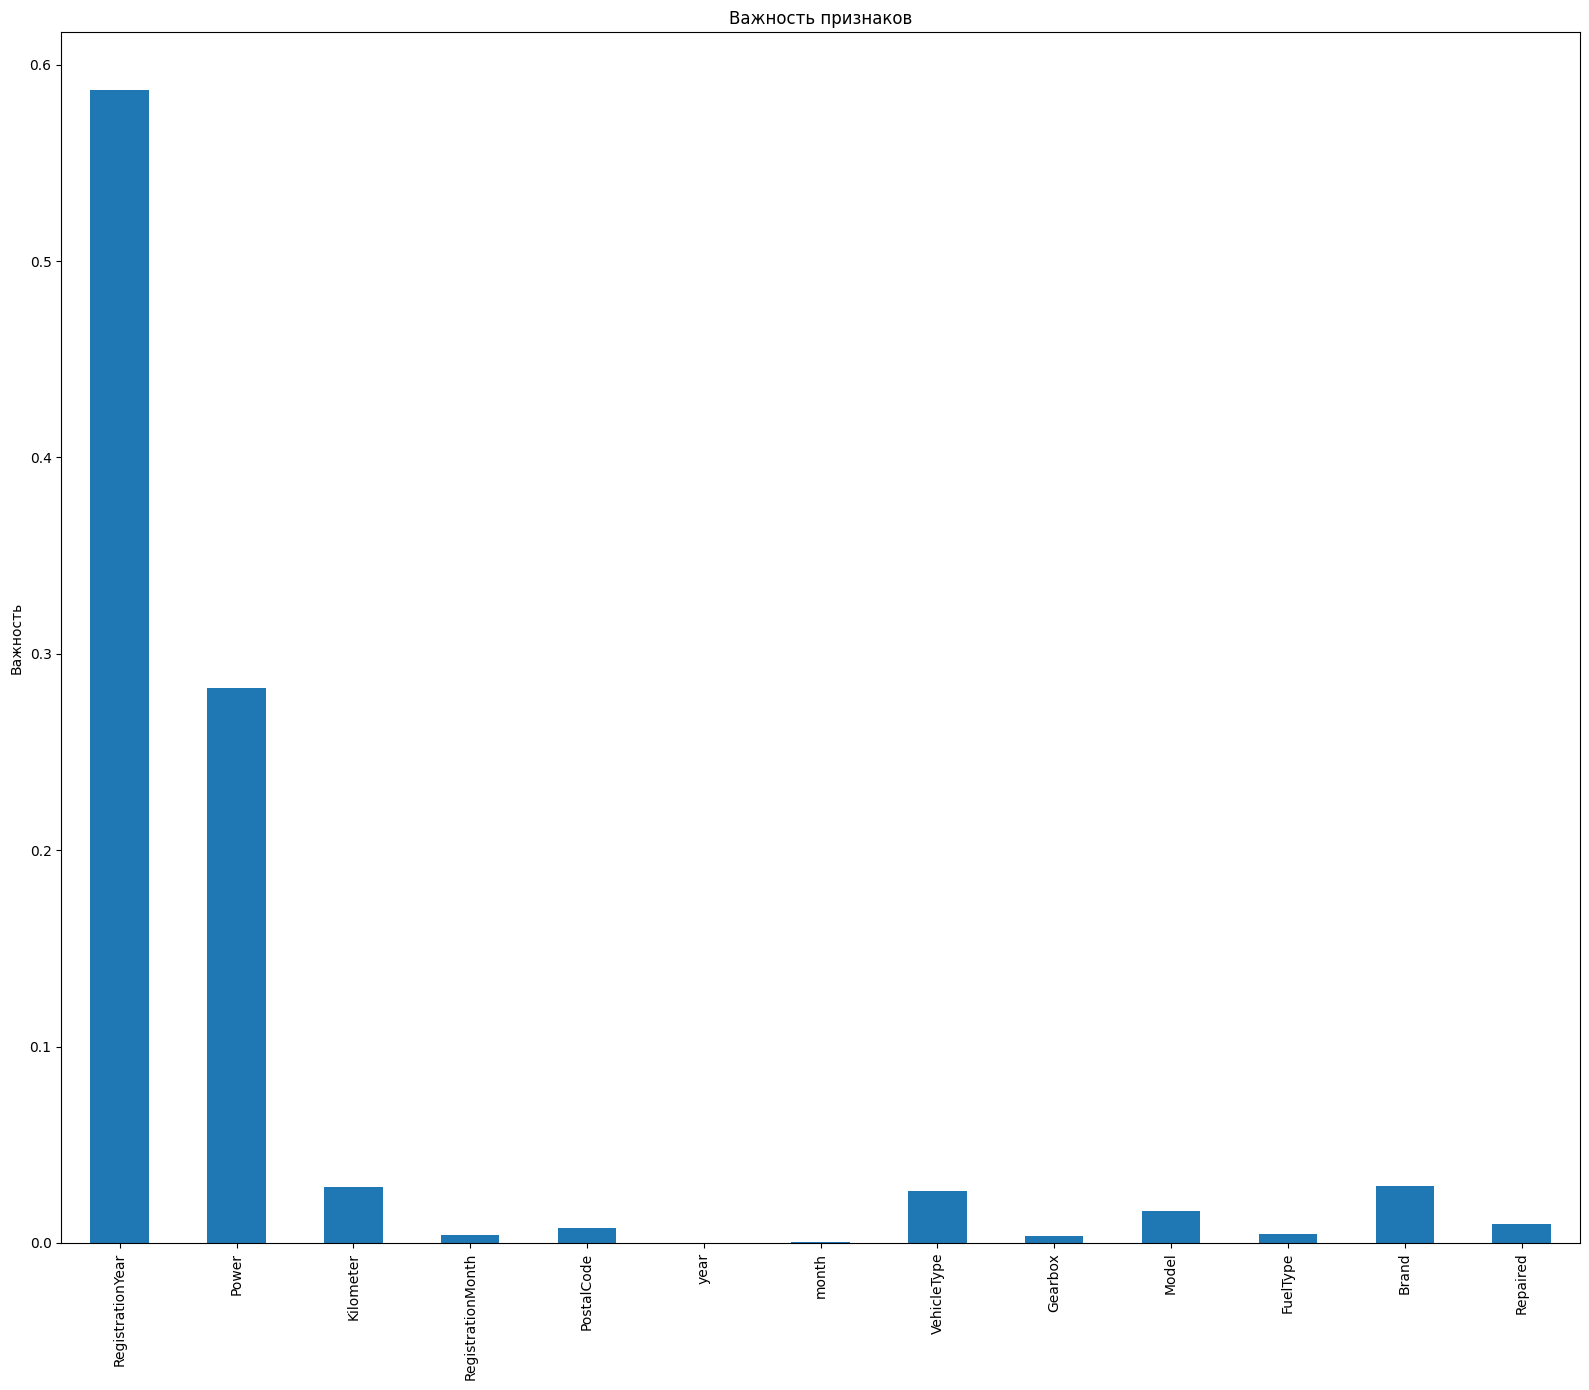

In [335]:
DT_feat_imp = pd.Series(model.feature_importances_,
                         features_train.columns)

fig, ax = plt.subplots(figsize=(16,14))
DT_feat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Самый важный признак - год регистрации, что логично, но только для большинства машин со средней ценой, второй выделяющийся - мощность, если больше мощность, то, как правило, люксовее авто, все логично.

### Проверка адекватности модели

Проверим адекватность модели:

In [336]:
# создаем объект dummy со стратегией заполнения средним
dummy_reg = DummyRegressor(strategy="mean")
# обучаем на трейне
dummy_reg.fit(features_train, target_train)
predict_test = dummy_reg.predict(features_test)
# считаем метрику
mean_squared_error(target_test, predict_test)**0.5

4503.888331740954

Значение метрики намного больше рассчитанного, что подтверждает адекватность выбранной модели.

### Промежуточные выводы

Протестировали выбранную модель DecisionTreeRegressor(max_depth=12, random_state=12345).

Результаты тестирования показали, что метрика RMSE = 2050, что удовлетворяет требованию  RMSE < 2500. 

Время обучения - 0.605 с, время предсказания модели - 0.008 с.

## Общие выводы

**Целью проекта** являлась разработка функционала по прогнозированию цены автомобиля для приложения сервиса по продаже автомобилей с пробегом «Не бит, не крашен».
Для реализации функционала по прогнозированию необходимо было предложить модель, удовлетворяющую трем критериям: минимальная метрика RMSE, минимальное время обучения и минимальное время предсказания. Ограничения: метрика RMSE не должна превышать значение 2500.

**В ходе выполнения проекта:**
- проведена загрузка исходных данных;
- данные изучены и предобработаны: удалены аномальные значения (23483, что составило 6.6% от общего числа данных), основная часть удалена из целевого признака - при обучении с учителем необходимо иметь достоверные адекватные  значения признака, поэтому все подозрительные значения были удалены; для заполнения пропусков использовался метод ближайших соседей; перед заполнением пропусков данные были разделены на выборки и проведено преобразование нечисловых признаков в числовые; после заполнения пропусков выполнено масштабирование признаков и проверка на мультиколлинеарность;
- исследованы четыре модели: решающее дерево, случайный лес, LightGBM и Catboost. Гиперпараметры подбирались с помощью оптимизатора optuna; В ходе исследования получены модели с подходящими параметрами:
DecisionTreeRegressor(max_depth=12, random_state=12345);
RandomForestRegressor(max_depth=21, n_estimators=10, random_state=12345);
LGBMRegressor(n_estimators=200, num_leaves=s61);
CatBoostRegressor(random_state=12345, max_depth=11, n_estimators=50);
- по рассчитанным параметрам - критериям установлено: наилучшей моделью по качеству предсказания является LGBMRegressor(n_estimators=200, num_leaves=s61).
наилучшей моделью по времени обучения и предсказания является DecisionTreeRegressor(max_depth=12, random_state=12345).
в совокупности по всем трем критериям наилучшей моделью является модель DecisionTreeRegressor(max_depth=12, random_state=12345), несмотря на худшую метрику RMSE, которая все же удовлетворяет требуемому значению <2500;
- выбрана модель DecisionTreeRegressor(max_depth=12, random_state=12345) и протестирована:
результаты тестирования показали, что метрика RMSE = 2050, что удовлетворяет требованию RMSE < 2500.
Время обучения и время предсказания модели имели ожидаемые величины.

В то же время необходимо отметить важное обстоятельство: в условиях ограничения на временные ресурсы при выполнении проекта мы ограничиваемся числом прогонов оптимизатора по параметрам, а также используем не все параметры моделей, в сявзи с чем при запуске ноутбука значения рассчитываемых критериев имеют значительный разброс и тип и параметры лучшей модели меняются. Поэтому более корректным будет отметить, что при данном запуске лучшей является модель DecisionTreeRegressor(max_depth=12, random_state=12345).

**Таким образом**, для реализации функционала по прогнозированию цены автомобиля в приложении сервиса подходящей моделью является DecisionTreeRegressor(max_depth=12, random_state=12345) с метрикой RMSE = 2050, временем обучения ~0.6-0.7 c и временем предсказания ~0.007-0.010 c.

## Вывод для начальства

Целью проекта являлась разработка функционала по прогнозированию цены автомобиля для приложения сервиса. Для реализации функционала по прогнозированию необходимо было предложить модель, удовлетворяющую трем критериям: минимальная метрика RMSE, минимальное время обучения и минимальное время предсказания. Ограничения: метрика RMSE не должна превышать значение 2500. 

Предлагается модель DecisionTreeRegressor(max_depth=12, random_state=12345) с метрикой RMSE = 2050, временем обучения ~0.6-0.7 c и временем предсказания ~0.007-0.010 c.